## Images

In [8]:
import heapq
import numpy as np
import pandas as pd
from skimage import io, img_as_float32
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.segmentation import find_boundaries
from scipy import ndimage
from skimage import exposure
from skimage import color
import os, sys
from DeCRISP import decrisp as dcp
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [9]:
n_channels = 2
n_cycles = 5

In [10]:
with open('./data/20210714sg2NEB_masks_mem_removecell.npy', 'rb') as m:
    masks_mem = np.load(m)
    
# # Use the following on your VM, and comment the above
# useFiltered = False

# filehandler = open('./data/20210928Sg2HBNEB_segmentation_2021-09-28.pickle', 'rb')
# masks_mem, masks_nuc, max_img, mask_dict = pickle.load(filehandler)

# if useFiltered == True:
#     filteredMasks = np.zeros(masks_mem.shape)
#     outputFlat = filteredMasks.ravel() #ravel references the original n-dimensional object in memory
#     for idx in mask_dict.keys():
#         indices = mask_dict[idx]['Membrane Pixels']
#         outputFlat[indices] = idx
#     masks_mem = filteredMasks
# filehandler.close()

# fig, ax = plt.subplots(1, 1, figsize=(30, 30))
# ax.imshow(find_boundaries(masks_mem))
# plt.show()

In [11]:
with open('./data/registered20210714_sg2NEB.npy', 'rb') as f:
    X = np.load(f)
    
# # Use the following on your VM, and comment the above
# opdir = './data/'
# reg_stack = pickle.load(open(opdir+'RegisteredImages_Xenograft_P1_C2-vfinal.pkl', 'rb'))

# X = []
# for i in range(n_channel):
#     for j in range(n_cycle):
#         X.append(reg_stack[j][i,])
# X = np.array(X)
# X = X.reshape((X.shape[0], 1, X.shape[1], X.shape[2]))

In [12]:
X.shape

(10, 1, 2048, 1280)

In [24]:
# for i in range(X.shape[0]):
#     plt.figure(dpi=250)
#     plt.imshow(X[i, 0,])

In [14]:
up = 10
down = 1800
left = 30
right = 1140

Xcenter = dcp.remove_border(X, up=up, down=down, left=left, right=right)

In [25]:
# for i in range(X.shape[0]):
#     plt.figure(dpi=250)
#     plt.imshow(Xcenter[i, 0,])

## Codebook

The most important is to make sure the codebook and the images are of the same order

In [16]:
codebook = pd.read_csv('./data/CRISPRmap_pilot_codebook_default.csv', dtype=np.int, header=None)
codebook = np.array(codebook)
codebook

array([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0]])

In [17]:
codebook.shape

(10, 10)

## Background subtraction and normalization

In [22]:
Xnorm = dcp.normalization(dcp.background_subtract(Xcenter, sigma=3))

## Thresholding

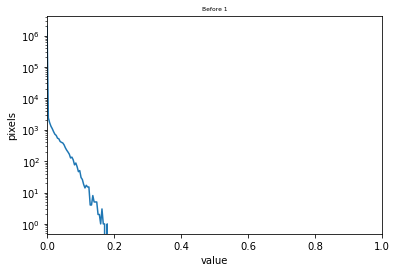

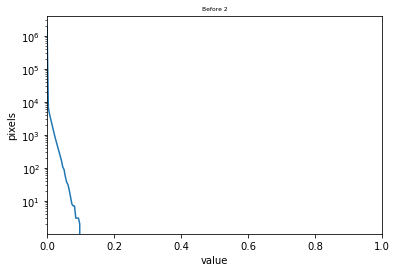

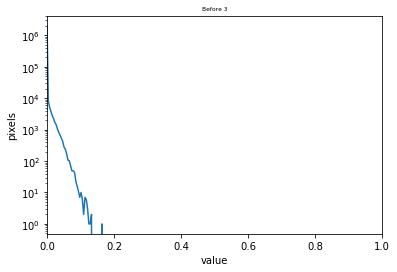

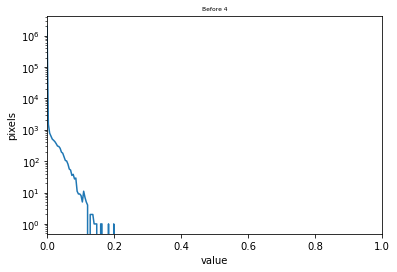

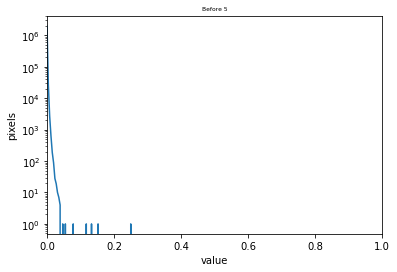

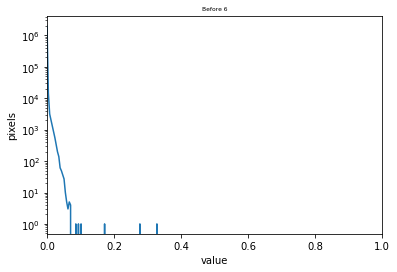

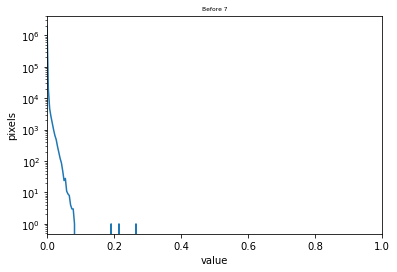

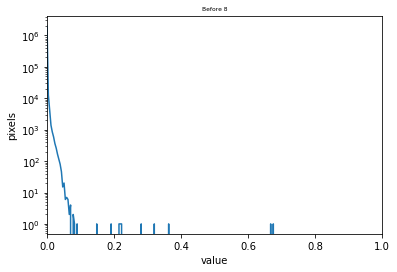

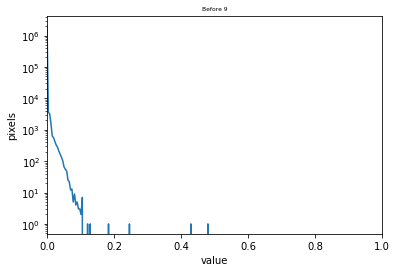

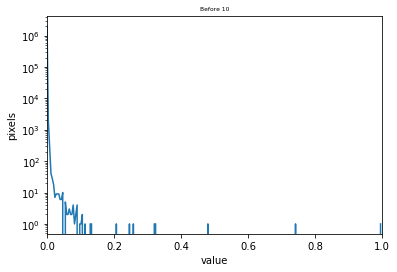

In [26]:
# Distributions before thresholding
for i in range(Xnorm.shape[0]):
    histogram, bin_edges = np.histogram(Xnorm[i, 0, ], bins=256, range=(0, 1))
    plt.figure()
    plt.title(f"Before {i+1}", fontsize=6)
    plt.xlabel("value")
    plt.ylabel("pixels")
    plt.semilogy(bin_edges[0:-1], histogram)
    plt.xlim([0.0, 1.0])
    plt.show()

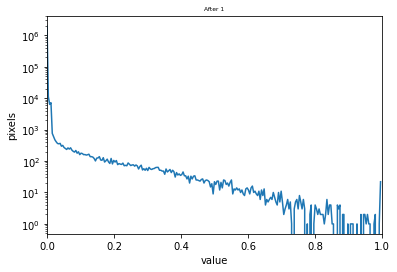

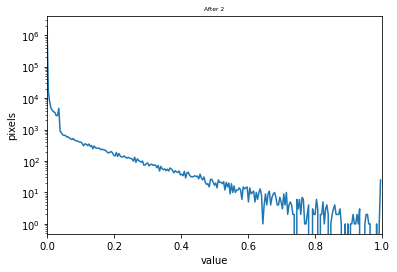

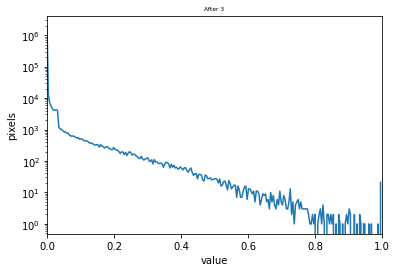

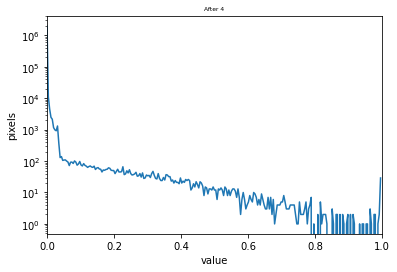

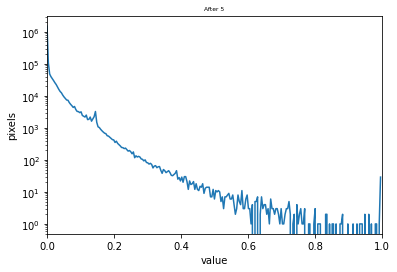

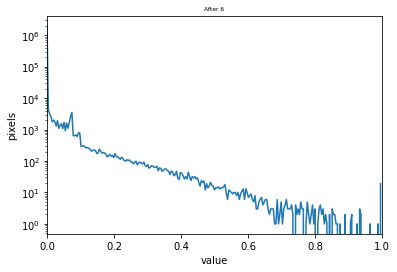

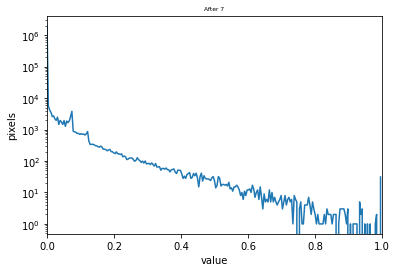

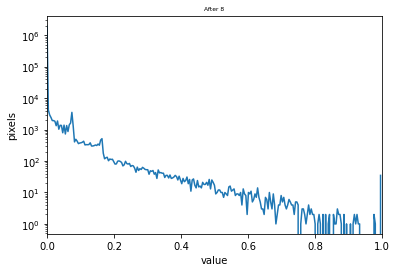

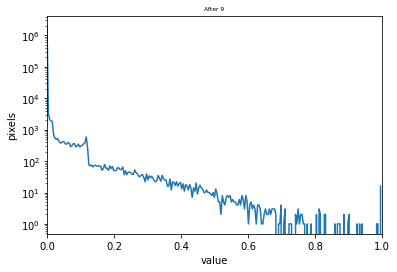

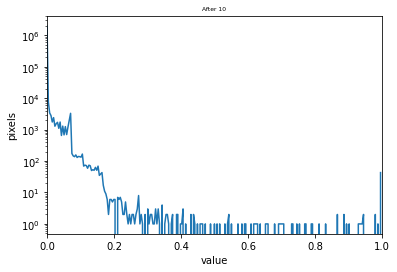

In [29]:
# Don't split this cell
upper = dcp.upper_thresh(Xnorm, n_channels=n_channels, n_cycles=n_cycles, min_bin=5)
Xthresh = dcp.upper_collapse(Xnorm, upper)

# After
for i in range(Xthresh.shape[0]):
    Xthresh[i, 0, ] = dcp.normalization(Xthresh[i, 0, ])
    histogram, bin_edges = np.histogram(Xthresh[i, 0, ], bins=256, range=(0, 1))
    plt.figure()
    plt.title(f"After {i+1}", fontsize=6)
    plt.xlabel("value")
    plt.ylabel("pixels")
    plt.semilogy(bin_edges[0:-1], histogram)
    plt.xlim([0.0, 1.0])
    plt.show()

## Prediction

In [36]:
cell_table = dcp.create_celltable(Xthresh, masks_mem, up, left, percentile=99)

0.013290852474160442
0.04886737144451599
0.07975513471408836
0.007759883996086583
0.14541254748790924
0.07179053381246486
0.08309565331768447
0.06919100023505595
0.007870486338439247
0.02657311844376497


In [ ]:
# pd.DataFrame(cell_table).to_csv('./result/crisprmap20210714sg2NEB_cell_table.csv')

In [37]:
cell_corr = dcp.cal_metric(cell_table, codebook)
corr_thresh = 0.001
alpha = 0.05  
beta = 0.8  # power
thresh_corr_diff = 0.26
cell_id = pd.DataFrame(dcp.argmax_thresh(cell_corr, axis=1, thresh=corr_thresh), columns=['barcode'])
cell_id['correlation_max'] = dcp.minmax(np.max(cell_corr, axis=1), min_all=np.min(cell_corr), max_all=np.max(cell_corr))
cell_id['correlation_2nd_max'] = dcp.minmax([heapq.nlargest(2, cell_corr[i,])[1] for i in cell_id.index], min_all=np.min(cell_corr), max_all=np.max(cell_corr))
cell_id['correlation_difference'] = cell_id['correlation_max'] - cell_id['correlation_2nd_max']
cell_id['select_by_correlation'] = cell_id['correlation_difference'] > thresh_corr_diff
cell_id['spots_max'] = np.max(cell_table, axis=1)
cell_id['spots_sum'] = np.sum(cell_table, axis=1)
cell_id['spots_needed'] = cell_id['correlation_max'].apply(dcp.sample_size, alpha=alpha, beta=beta)
cell_id['select_by_spots'] = cell_id['spots_sum'] > cell_id['spots_needed']
cell_id['selected'] = cell_id['select_by_correlation'] & cell_id['select_by_spots']
cell_id['cells_with_spots'] = cell_id['spots_sum'] > 0
cell_id.head()

,barcode,correlation_max,correlation_2nd_max,correlation_difference,select_by_correlation,spots_max,spots_sum,spots_needed,select_by_spots,selected,cells_with_spots
0,-1,0.000000,0.000000,0.000000,False,0.0,0.0,31395550336760,False,False,False
1,3,0.942808,0.235702,0.707106,True,2.0,5.0,5,False,False,True
2,9,0.984362,0.581668,0.402693,True,25.0,53.0,4,True,True,True
3,3,0.583874,0.544949,0.038925,False,12.0,44.0,20,True,False,True
4,6,0.923447,0.537416,0.386031,True,65.0,211.0,6,True,True,True


In [38]:
color_dict = {
    0: (0,0,255),
    1: (0,255,0),
    2: (255, 0, 0),
    3: (0,255,255),
    4: (255,0,255),
    5: (255,255,0),
    6: (255,127,0),
    7: (0,127,0),
    8: (127,0,0),
    9: (255,255,255),
    10: (127, 127, 127)
}

In [40]:
# Plot all cells
cell_bar = np.array(cell_id.barcode).ravel()
mask = np.zeros(masks_mem.shape)
for i, l in enumerate(cell_bar[1:]):
    mask[masks_mem==i+1] = l+1
mask_color = np.zeros((*mask.shape, 3))
for i in range(len(color_dict)): 
    mask_color[mask==i+1] = color_dict[i]
mask_color = mask_color[up:down, left:right]
mask_color[find_boundaries(masks_mem[up:down, left:right]),] = (127, 127, 127)
plt.figure(dpi=200)    
plt.imshow(mask_color.astype(np.uint8), origin='lower')

Text(0.5, 1.0, 'Selected cells')

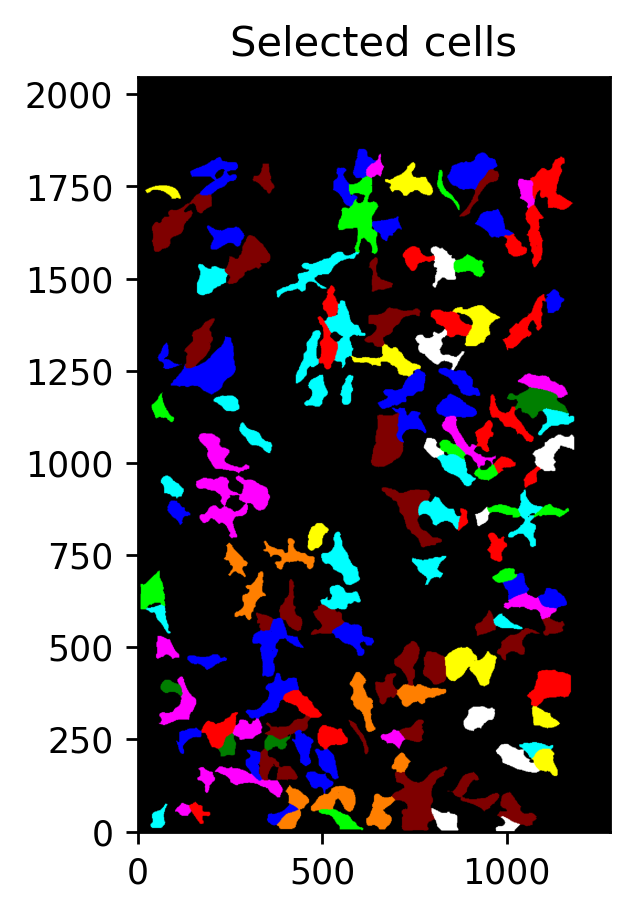

In [43]:
# Plot selected cells
no_low = cell_id.barcode[cell_id.selected==True]
mask_color_nl = np.zeros((*masks_mem.shape, 3))
for i in no_low.index:
    if i>0:
        mask_color_nl[np.array(masks_mem)==i] = color_dict[no_low[i]]
plt.figure(dpi=250)
plt.imshow(mask_color_nl.astype(np.uint8), origin='lower')
plt.title('Selected cells')